<a href="https://colab.research.google.com/github/Haebuk/sparta_ML/blob/main/4%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5_02_%EA%B3%BC%EC%9D%BC_%EC%A2%85%EB%A5%98_%EC%98%88%EC%B8%A1_(TL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터셋 다운로드

과일 사진 데이터셋

https://www.kaggle.com/moltean/fruits

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'haebuk' # username
os.environ['KAGGLE_KEY'] = '6c964b083d7917c00cc846d7c4b939cf' # key

In [2]:
!kaggle datasets download -d moltean/fruits

 99% 752M/760M [00:26<00:00, 39.9MB/s]
100% 760M/760M [00:26<00:00, 29.6MB/s]


In [3]:
!unzip -q fruits.zip

# 패키지 로드

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 이미지 증강 기법

이번에는 `flow_from_directory` 메소드를 사용하여 데이터셋이 저장된 폴더에서 직접 데이터를 읽어오겠습니다!

In [5]:
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory(
  'fruits-360/Training', # 이 폴더에서 읽어와서 알아서 클래스 별로 구별까지 해줌
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical', # 라벨 여러개일때
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'fruits-360/Test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
from pprint import pprint
pprint(train_gen.class_indices) # 클래스 출력

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Apricot': 13,
 'Avocado': 14,
 'Avocado ripe': 15,
 'Banana': 16,
 'Banana Lady Finger': 17,
 'Banana Red': 18,
 'Beetroot': 19,
 'Blueberry': 20,
 'Cactus fruit': 21,
 'Cantaloupe 1': 22,
 'Cantaloupe 2': 23,
 'Carambula': 24,
 'Cauliflower': 25,
 'Cherry 1': 26,
 'Cherry 2': 27,
 'Cherry Rainier': 28,
 'Cherry Wax Black': 29,
 'Cherry Wax Red': 30,
 'Cherry Wax Yellow': 31,
 'Chestnut': 32,
 'Clementine': 33,
 'Cocos': 34,
 'Corn': 35,
 'Corn Husk': 36,
 'Cucumber Ripe': 37,
 'Cucumber Ripe 2': 38,
 'Dates': 39,
 'Eggplant': 40,
 'Fig': 41,
 'Ginger Root': 42,
 'Granadilla': 43,
 'Grape Blue': 44,
 'Grape Pink': 45,
 'Grape White': 46,
 'Grape White 2': 47,
 'Grape White 3': 48,
 'Grap

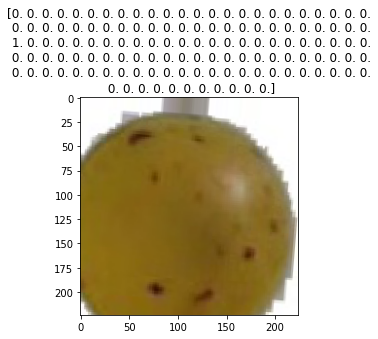

In [7]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])
# 증강, 원핫 된 상태

# 전이 학습

https://keras.io/api/applications/

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

input = Input(shape=(224, 224, 3))

# 출력 레이어 빼고
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
# 출력 레이어 조정
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(131, activation='softmax')(x) # 클래스 131개, 소프트맥스

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

87916544/87910968 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# 학습

`ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)`

`val_acc`가 높은 1개의 모델(save_best_only)을 model.h5 라는 파일로 저장한다.

https://keras.io/api/callbacks/model_checkpoint/

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20, # epochs 복수형으로 쓰기!
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
2116/2116 [==============================] - 822s 378ms/step - loss: 2.1626 - acc: 0.4235 - val_loss: 1.9133 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53332, saving model to model.h5
Epoch 2/20
2116/2116 [==============================] - 792s 374ms/step - loss: 0.4574 - acc: 0.8567 - val_loss: 0.4796 - val_acc: 0.8632

Epoch 00002: val_acc improved from 0.53332 to 0.86319, saving model to model.h5
Epoch 3/20
2116/2116 [==============================] - 795s 375ms/step - loss: 0.1943 - acc: 0.9374 - val_loss: 0.6841 - val_acc: 0.8809

Epoch 00003: val_acc improved from 0.86319 to 0.88086, saving model to model.h5
Epoch 4/20
2116/2116 [==============================] - 795s 376ms/step - loss: 0.1377 - acc: 0.9567 - val_loss: 1.0026 - val_acc: 0.9165

Epoch 00004: val_acc improved from 0.88086 to 0.91652, saving model to model.h5
Epoch 5/20
2116/2116 [==============================] - 794s 375ms/step - loss: 0.1041 - acc: 0.9676 - val_loss: 0.1636 - val_a

# 학습 결과 그래프

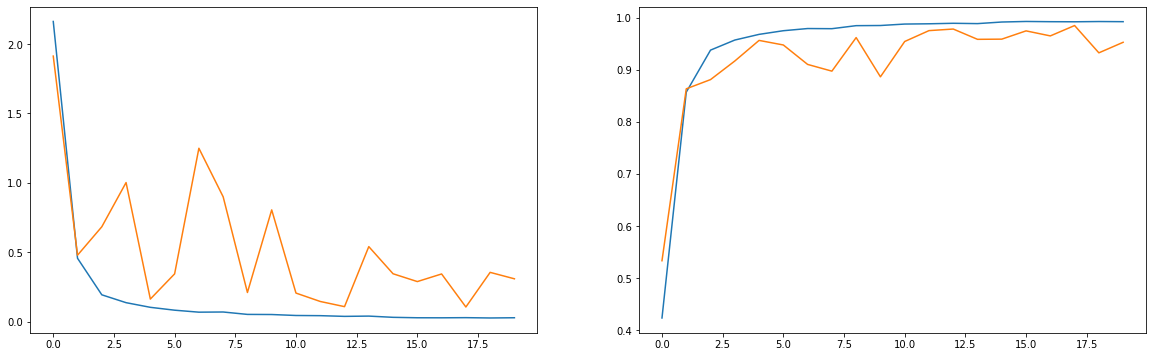

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

# 학습된 모델 로드

In [11]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


# 테스트

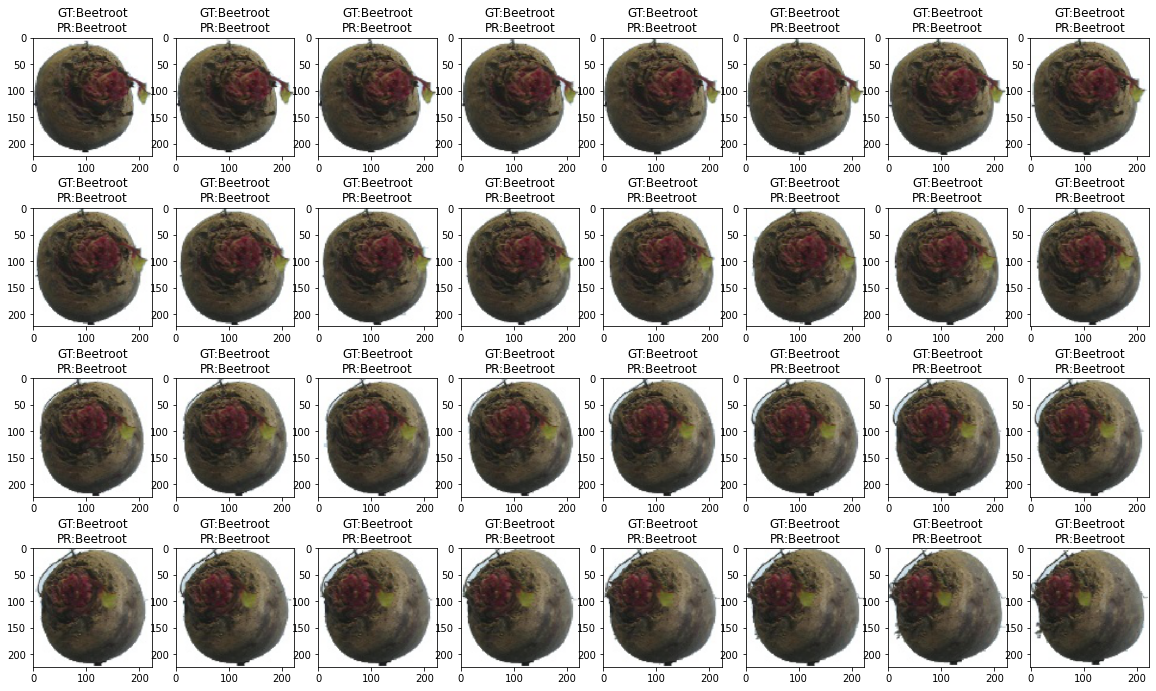

In [12]:
test_imgs, test_labels = test_gen.__getitem__(100) # 100번째 배치 로드

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)